# Приближенное решение смешанной краевой задачи для неоднородного волнового уравнения

## Вариант 20

> <span style="font-style:normal; font-size:12pt;"> 
        <ol> 
            <li>Найти численное решение смешанной краевой задачи для неоднородного волнового уравнения при x на отрезке [0,1].
                Для расчета решения использовать схему "крест" с шагом h = 0.05 по переменной x. Предусмотреть возможность
                произвольного задания шага по переменной t и времени окончания расчета (по умолчанию
                τ = 0.05 и T = 1, соответственно). </li>
            <li>Для получения решения использовать начальные и граничные условия первого и
                второго порядка точности.</li>
        </ol> 
    <p>  Для сравнения приведено точное решение u0(x,t). </p>
    
$$
\begin{equation}
u_{tt} = \frac{1}{2}u_{xx} - \frac{3}{2} + \frac{xe^{-t}}{2(4 - x^2)^{3/2}} + e^{-t} \arccos{\frac{x}{2}}, \\
u(x,0)   = \frac{3}{2} x^2 + \arccos{\frac{x}{2}},              \\ 
u_t(x,0) = -\arccos{\frac{x}{2}},                      \\ 
2u(0,t) + u_x(0,t) = (\pi - \frac{1}{2}) e^{-t}, \\
u(1,t)   = \frac{3}{2} + \frac{\pi}{3}e^{-t},    \\ 
u0(x,t)  = \frac{3}{2}x^{2} + e^{-t} \arccos{\frac{x}{2}}
\end{equation}
$$

In [1]:
%matplotlib widget

import numpy  as np
import pandas as pd
from matplotlib           import pyplot as plt
from matplotlib.widgets   import Slider, Button
from mpl_toolkits.mplot3d import axes3d
from matplotlib           import cm

## Постановка задачи

In [2]:
# неоднородность
def f(x, t):
    return (-3 / 2) + (1 / 2) * x * np.exp(-t) / np.power(4 - x**2, 3 / 2) + np.exp(-t) * np.arccos(x / 2) 

# начальные условия
def phi_1(x):
    return (3 / 2) * x**2 + np.arccos(x / 2)

def phi_2(x):
    return (-1) * np.arccos(x / 2)


# граничные условия
def gamma_1(t):
    return (np.pi - 1 / 2) * np.exp(-t)

def gamma_2(t):
    return  (3 / 2) + np.pi * np.exp(-t) / 3


# Параметры
def alpha_1(t):
    return 1

def beta_1(t):
    return 2

def alpha_2(t):
    return 0

def beta_2(t):
    return 1

# точное решение для анализа
def u(x, t):
    return (3 / 2) * x**2 + np.exp(-t) * np.arccos(x / 2)


# Область значений и шаг по x
left  = 0
right = 1
h     = 0.05

# Область значений и шаг по t
t0 = 0
T  = 1

# коэффициент волнового уравнения
a = np.sqrt(1 / 2)

### Условие Куронта

In [3]:
n = int(input('Введите количество узлов на оси X: '))
print(n)

Введите количество узлов на оси X: 350
350


In [4]:
# параметры сетки
# Через условие Куронта определим шаг временной сетки

"""
    Условие Куронта:
    a * t / h < 1

"""

h = (right - left) / n
t = round(0.9 * h / a, 6)

print("\nПространственная ось\n", "левая граница: ", left, "\tправая граница: ", right, "\tшаг: ", h)
print("\nВременная ось\n", "вверхняя граница: ", T, "\tшаг: ", t)


Пространственная ось
 левая граница:  0 	правая граница:  1 	шаг:  0.002857142857142857

Временная ось
 вверхняя граница:  1 	шаг:  0.003637


### Точное решение

In [5]:
x_plot = np.linspace(left, right, round((right - left) / h) + 1)       # координатная сетка
t_plot = np.linspace(t0, T, round((T - t0) / t) + 1)                   # временная сетка (слои)

X, Y = np.meshgrid(x_plot, t_plot)
Z0 = u(X, Y)

##### График решения

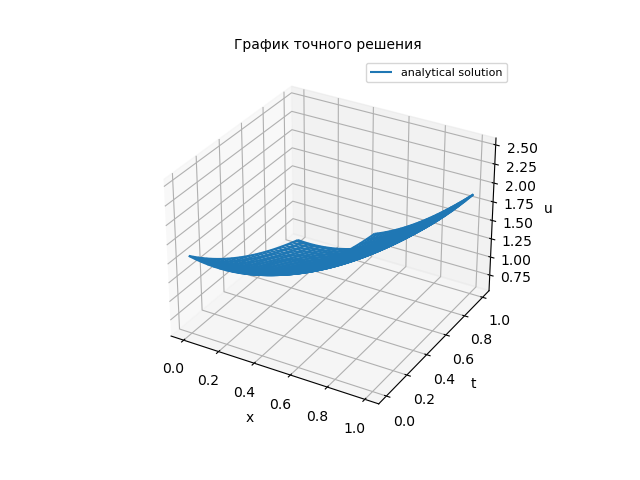

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(X, Y, Z0, cmap=cm.coolwarm)
ax.plot_wireframe(X, Y, Z0, rstride=10, cstride=12, label='analytical solution')

ax.set_xlabel('x', fontsize=10)        
ax.set_ylabel('t', fontsize=10)
ax.set_zlabel('u', fontsize=10)

plt.title('График точного решения', fontsize=10)
plt.legend(fontsize=8)

plt.show()

## Численное решение

## 1. Начальные и граничные условия первого порядка точности

In [7]:
u_plot1 = []   # численное решение

In [8]:
# первые два слоя по времени из начальных условий

layer_0 = [phi_1(xk) for xk in x_plot]
layer_1 = [phi_2(xk) * t + uk_0 for xk, uk_0 in zip(x_plot, layer_0)]

u_plot1.append(layer_0)
u_plot1.append(layer_1)

In [9]:
# Считаем следующие слои
# Определяем значения на границе из граничных условий

layer_i = layer_1
layer_j = layer_0

for n in range(1, len(t_plot) - 1):
    layer = []                       # вычисляемый слой
    
    for k in range(1, len(x_plot) - 1):
        u_nk = ((a**2 * t**2 / h**2) * (layer_i[k + 1] - 2 * layer_i[k] + layer_i[k - 1]) + 
                t**2 * f(x_plot[k], t_plot[n]) + 2 * layer_i[k] - layer_j[k])
        layer.append(u_nk)
    
    u_n0 = ((gamma_1(t_plot[n + 1]) - alpha_1(t_plot[n + 1]) * layer[0] / h)  / 
            (beta_1(t_plot[n + 1]) - alpha_1(t_plot[n + 1]) / h))
    u_nN = ((gamma_2(t_plot[n + 1]) + alpha_2(t_plot[n + 1]) * layer[-1] / h) / 
            (alpha_2(t_plot[n + 1]) / h + beta_2(t_plot[n + 1])))
    
    layer.insert(0, u_n0)
    layer.append(u_nN)
    
    u_plot1.append(layer)
    
    layer_j = layer_i
    layer_i = layer

In [10]:
X, Y = np.meshgrid(x_plot, t_plot)
Z0   = u(X, Y)
Z    = np.asarray(u_plot1)

##### График решения

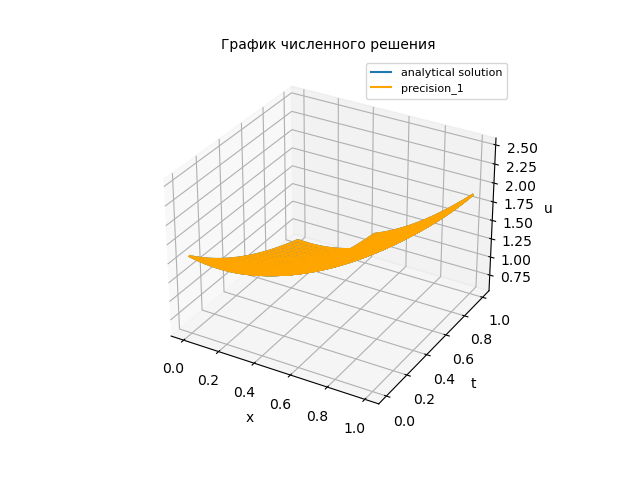

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(X, Y, Z0, cmap=cm.coolwarm)
ax.plot_wireframe(X, Y, Z,  rstride=10, cstride=10,                 label='analytical solution')
ax.plot_wireframe(X, Y, Z0, rstride=10, cstride=10, color='orange', label='precision_1')

ax.set_xlabel('x', fontsize=10)        
ax.set_ylabel('t', fontsize=10)
ax.set_zlabel('u', fontsize=10)

plt.title('График численного решения', fontsize=10)
plt.legend(fontsize=8)

plt.show()

### Погрешность

In [12]:
errors = []

for n in range(len(Z0)):
    errors_i = [abs(z0 - z) for z0, z in zip(Z0[n], Z[n])]
    errors.append(errors_i)

In [13]:
X, Y = np.meshgrid(x_plot, t_plot)
errors = np.asarray(errors)

No handles with labels found to put in legend.


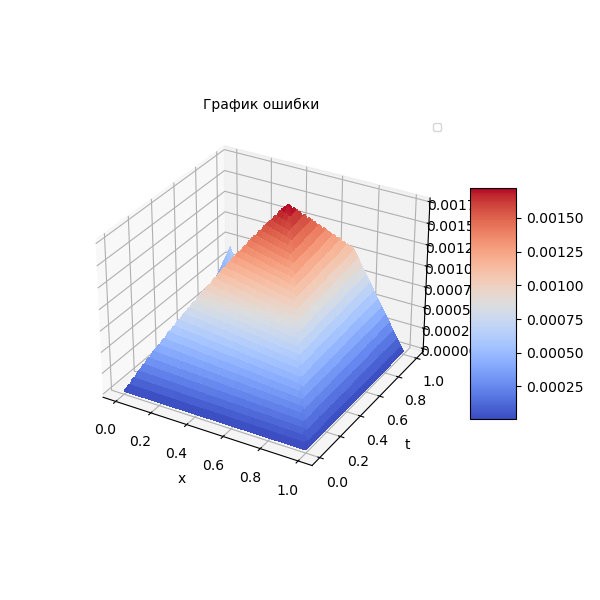

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, errors, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.plot_wireframe(X, Y, errors,  rstride=10, cstride=10, color='', label='analytical solution')

ax.set_xlabel('x', fontsize=10)        
ax.set_ylabel('t', fontsize=10)
ax.set_zlabel('error', fontsize=10)

plt.title('График ошибки', fontsize=10)
plt.legend(fontsize=8)

plt.show()

<span style="font-style:italic; font-size:14pt;"> 
    <p>
        Максимальная ошибка:
    </p>


In [15]:
errors = errors.flatten()
max(errors.tolist())

0.0017578584323210134

### Временная зависимость

In [16]:
def update(val):
    ydata  = u_plot1[int(np.where(t_plot == val)[0])]
    line.set_ydata(ydata)
    fig.canvas.draw_idle()

def reset(event):
    time_slider.reset()

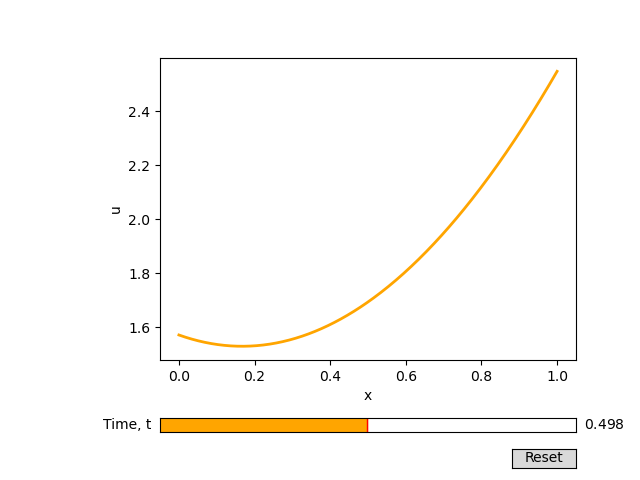

In [17]:
fig, ax = plt.subplots()
line,   = plt.plot(x_plot, u_plot1[0], lw = 2, color = 'orange')

ax.set_xlabel('x')
ax.set_ylabel('u')


plt.subplots_adjust(left = 0.25, bottom = 0.25)

ax_time = plt.axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(
    ax      = ax_time,
    label   = 'Time, t',
    valmin  = t0,
    valmax  = T,
    valinit = (t0 + T) / 2,
    valstep = t,
    color   = 'orange'
)


time_slider.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button  = Button(resetax, 'Reset', hovercolor='0.975')

button.on_clicked(reset)


plt.show()

## 2. Начальные и граничные условия второго порядка точности

In [18]:
u_plot2 = []   # численное решение

In [19]:
# первые два слоя по времени из начальных условий

layer_0 = [phi_1(xk) for xk in x_plot]
layer_1 = [uk_0 + phi_2(xk) * t + (t**2 / 2) * (a**2 * (3 - (1 / 8) * xk / np.power(1 - (xk / 2)**2, 3 / 2)) + f(xk, 0)) for xk, uk_0 in zip(x_plot, layer_0)]

u_plot2.append(layer_0)
u_plot2.append(layer_1)

In [20]:
# Считаем следующие слои
# Определяем значения на границе из граничных условий

layer_i = layer_1
layer_j = layer_0

for n in range(1, len(t_plot) - 1):
    layer = []                       # вычисляемый слой
    
    for k in range(1, len(x_plot) - 1):
        u_nk = ((a**2 * t**2 / h**2) * (layer_i[k + 1] - 2 * layer_i[k] + layer_i[k - 1]) + 
                t**2 * f(x_plot[k], t_plot[n]) + 2 * layer_i[k] - layer_j[k])
        layer.append(u_nk)
    
    u_n0 = ((2 * h * gamma_1(t_plot[n + 1]) - 4 * alpha_1(t_plot[n + 1]) * layer[0]  + alpha_1(t_plot[n + 1]) * layer[1]) / 
            (2 * h * beta_1(t_plot[n + 1])  - 3 * alpha_1(t_plot[n + 1])))
    u_nN = ((2 * h * gamma_2(t_plot[n + 1]) + 4 * alpha_2(t_plot[n + 1]) * layer[-1] - alpha_2(t_plot[n + 1]) * layer[-2]) / 
            (3 * alpha_2(t_plot[n + 1]) + 2 * h * beta_2(t_plot[n + 1])))
    
    layer.insert(0, u_n0)
    layer.append(u_nN)
    
    u_plot2.append(layer)
    
    layer_j = layer_i
    layer_i = layer

In [21]:
X, Y = np.meshgrid(x_plot, t_plot)
Z   = np.asarray(u_plot2)
Z0   = u(X, Y)

##### График решения

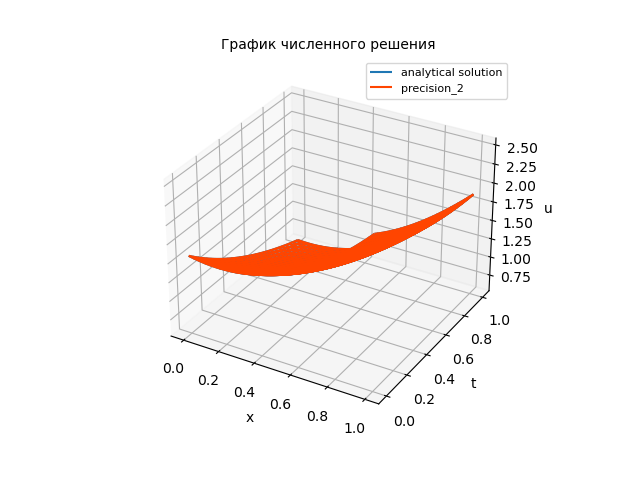

In [22]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

# ax.plot_surface(X, Y, Z0, cmap=cm.coolwarm)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, label='analytical solution')
ax.plot_wireframe(X, Y, Z0, rstride=10, cstride=10, color='orangered', label='precision_2')

ax.set_xlabel('x', fontsize=10)        
ax.set_ylabel('t', fontsize=10)
ax.set_zlabel('u', fontsize=10)

plt.title('График численного решения', fontsize=10)
plt.legend(fontsize=8)

plt.show()

### Погрешность

In [23]:
errors = []

for n in range(len(Z0)):
    errors_i = [abs(z0 - z) for z0, z in zip(Z0[n], Z[n])]
    errors.append(errors_i)

In [24]:
X, Y = np.meshgrid(x_plot, t_plot)
errors = np.asarray(errors)

No handles with labels found to put in legend.


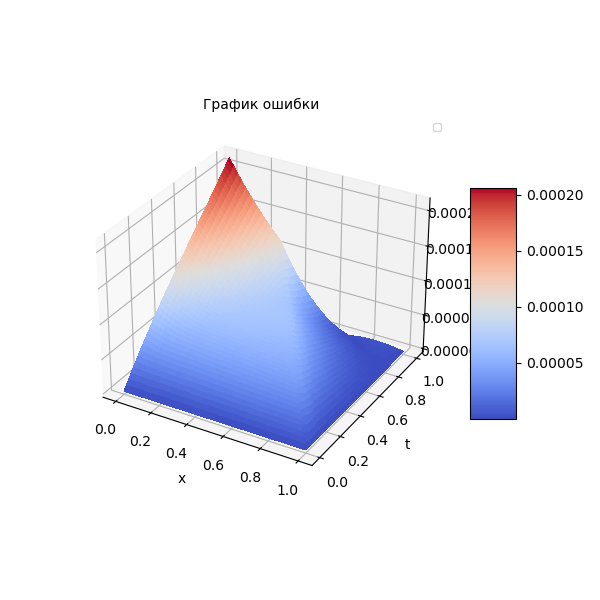

In [25]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, errors, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.plot_wireframe(X, Y, errors,  rstride=10, cstride=10, color='', label='analytical solution')

ax.set_xlabel('x', fontsize=10)        
ax.set_ylabel('t', fontsize=10)
ax.set_zlabel('error', fontsize=10)

plt.title('График ошибки', fontsize=10)
plt.legend(fontsize=8)

plt.show()

<span style="font-style:italic; font-size:14pt;"> 
    <p>
        Максимальная ошибка:
    </p>


In [26]:
errors = errors.flatten()
max(errors.tolist())

0.0002133341885186546